## CS345 Fall 2024 Assignment 4


In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge 
from sklearn.linear_model import ridge_regression 
import io

## Part 1:  Linear regression on medical insurance data

### The data

We will work on predicting a person's insurance charges based on a collection of features that include age, gender, body-mass-index (BMI), number of children, whether a person smokes, and the region in the US they live in.
Since the file contains string data in addition to numeric data let's first read the file using the Python `requests` module:

In [8]:
import requests
# if you don't have requests installed you can use urlopen which is part
# of the python standard library
# from urllib.request import urlopen
link = "https://github.com/asabenhur/CS345/raw/master/fall22/data/insurance.csv"
# retrieve the contents of the file
contents = requests.get(link)

Let's take a look at the first five rows of the data:

In [9]:
contents.text.split()[:5]

['age,sex,bmi,children,smoker,region,charges',
 '19,female,27.9,0,yes,southwest,16884.924',
 '18,male,33.77,1,no,southeast,1725.5523',
 '28,male,33,3,no,southeast,4449.462',
 '33,male,22.705,0,no,northwest,21984.47061']

As you can see the header specifies the names of the features:

```
age,sex,bmi,children,smoker,region,charges
```

The names are self explanatory.  We will use the last column as our label/target variable, and try to predict it from the other variables.

Since the data is a mix of numerical and categorical variables, we will need to do some work to create a feature matrix from this file.

This data has three types of features:

* Numerical data (the age, bmi, and children features)
* Categorical data that has one of two values (the sex and smoker features)
* Categorical data that has more than two possible values.  The "region" feature has the values "southwest", "southeast", "northwest", and "northeast".

Numerical data can be left as is (but will need to be standardized); binary categorical data can be converted to 0/1.  Categorical variables with more than two possible values require a different approach, which is called "one-hot-encoding", where each value receives its own feature, and the single categorical variable is replaced with a set of features.  The number of features equals the number of unique values that the categorical variable takes, and a categorical value is encoded as a vector of zeros, with a single value of one in the feature that corresponds to the given value.  Let us demonstrate this using the one-hot-encoder of scikit-learn on our "region" variable which has four possible values:

In [10]:
from sklearn.preprocessing import OneHotEncoder

# a mock dataset of regions:
X = [['southwest'], ['southeast'], ['northwest'], ['northeast'], ['southeast']]
# create an instance of one hot encoder
encoder = OneHotEncoder()
# apply it to the data:
encoder.fit_transform(X).toarray()
# we have converted the output of fit_transform from a sparse array
# type to a regular NumPy array so we can easily see the values

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

As you can see, the single variable was represented by four features, one for each possible value.

**Note:**  In your code you may not use the scikit-learn one-hot-encoder.

You might ask why not simply encode the four region values using the numbers 0-3.  The issue with doing that is that this representation imposes an order on the values, an order that does not necessarily reflect the relationship between these values in the real world.

### Your tasks

Your tasks are as follows:

* Create a feature matrix and labels vector from the data as described above.
* Split the data into separate train and test sets with 30% of the data reserved for testing.
* Evaluate the error of linear regression on the train and test sets.  In doing so, first standardize the features.  Note that not all the features should be standardized - only the age and BMI features need that, because their values are significantly larger than one.  Note that when standardizing, *only the features need to be standardized*.  The labels should remain unaltered.  This dataset can lead to a linear regression solution that suffers from numerical instabilities.  To address that, use the scikit-learn implementation of ridge regression with a very small value of the regularization parameter $\alpha$.
* As discussed in class, the magnitude of the components of the weight vector provide an indication of the usefulness of a feature. Based on the magnitude of the components of the weight vector, choose a subset of the features that are most useful for the regression task (note that large negative values also suggest usefulness).  Compare the error before and after removing the features with the lowest importance based on the weight vector.  Comment on your results.  Were the region features chosen?  If not, hypothesize why that is the case.
* As a baseline, compute the error of a naive regression method that for a given regression problem always returns the mean label value.  Compare this error with the error you got using linear regression and comment on the result.  Why is computing the error of this naive method a useful thing to do?

For evaluating regression error use mean asbsolute error (MAE).

In [18]:
df = pd.read_csv(link)
df.loc[df['sex'] == 'female', 'sex'] = 0
df.loc[df['sex'] == 'male', 'sex'] = 1
df.loc[df['smoker'] == 'no', 'smoker'] = 0
df.loc[df['smoker'] == 'yes', 'smoker'] = 1
y = df['charges']
df = df.drop(columns=['charges'])
df = pd.get_dummies(df, columns=['region'], dtype=float)
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_test['age'] = (X_test['age'] - X_test['age'].mean()) / X_test['age'].std()
X_test['bmi'] = (X_test['bmi'] - X_test['bmi'].mean()) / X_test['bmi'].std()
X_train['age'] = (X_train['age'] - X_train['age'].mean()) / X_train['age'].std()
X_train['bmi'] = (X_train['bmi'] - X_train['bmi'].mean()) / X_train['bmi'].std()

weights = ridge_regression(X, y, alpha=0.00001)

feature_names = X.columns
abs_weights = np.abs(weights)
sorted_indices = np.argsort(abs_weights)[::-1]
sorted_features = feature_names[sorted_indices]
important_features = sorted_features[:5]

X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

ridge = Ridge(alpha=0.00001)
ridge.fit(X_train_selected, y_train)
y_pred_selected = ridge.predict(X_test_selected)

ridge_full = Ridge(alpha=0.00001)
ridge_full.fit(X_train, y_train)
y_pred_full = ridge_full.predict(X_test)

mae_full = mean_absolute_error(y_test, y_pred_full)
mae_selected = mean_absolute_error(y_test, y_pred_selected)

print(f"mae for all features: {mae_full:.4f}")
print(f"mae for selected features: {mae_selected:.4f}")

region_features = [col for col in feature_names if 'region' in col]
selected_regions = [feat for feat in important_features if feat in region_features]

print(f"selected region features: {selected_regions}")


y_pred_naive = np.full_like(y_test, y_train.mean())

mae_naive = mean_absolute_error(y_test, y_pred_naive)
print(f'naive mae: {mae_naive:.4f}')

mae for all features: 4079.2602
mae for selected features: 5515.4269
selected region features: ['region_southeast', 'region_southwest', 'region_northwest', 'region_northeast']
naive mae: 9167.9570


Interestingly, the MAE after selecting features based on relevance was higher. Regions were included, as they had bigger weights than other factors like age, sex, bmi, or children.

The ridge regression MAE is much lower than the naive MAE, which suggests that the regression is successfully capturing relationships in the data.

## Part 2:  polynomial regression

In this part we will explore polynomial regression using the [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), which is distributed with scikit-learn.

In [19]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X = data.data
y = data.target

A complete description of the dataset and its features is contained in the `DESCR` attribute of the dataset:

```python
print(data.DESCR)
```

Let's plot a histogram of the labels:

(array([   9.,   14.,   61.,  255.,  538.,  676.,  546.,  803.,  881.,
         706.,  812.,  715.,  836.,  815.,  921.,  960.,  786.,  817.,
         703.,  505.,  620.,  661.,  578.,  508.,  432.,  439.,  463.,
         331.,  320.,  216.,  224.,  232.,  245.,  252.,  286.,  193.,
         160.,  149.,  117.,  133.,  104.,   99.,   80.,   90.,  106.,
          66.,   49.,   51.,   47., 1030.]),
 array([0.14999  , 0.2469904, 0.3439908, 0.4409912, 0.5379916, 0.634992 ,
        0.7319924, 0.8289928, 0.9259932, 1.0229936, 1.119994 , 1.2169944,
        1.3139948, 1.4109952, 1.5079956, 1.604996 , 1.7019964, 1.7989968,
        1.8959972, 1.9929976, 2.089998 , 2.1869984, 2.2839988, 2.3809992,
        2.4779996, 2.575    , 2.6720004, 2.7690008, 2.8660012, 2.9630016,
        3.060002 , 3.1570024, 3.2540028, 3.3510032, 3.4480036, 3.545004 ,
        3.6420044, 3.7390048, 3.8360052, 3.9330056, 4.030006 , 4.1270064,
        4.2240068, 4.3210072, 4.4180076, 4.515008 , 4.6120084, 4.7090088,
        

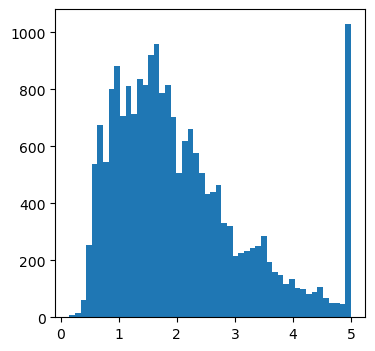

In [20]:
plt.figure(figsize=(4,4))
plt.hist(y, bins=50)

Here is your task:

* Compute the MAE of polynomial basis regression as a function of the degree of the monomials for the Boston housing dataset.  Start with degree equal to 1, i.e. using the features as-is, and compute the error for monomials with degrees 1 to 6.  In each case compute error for both the training set, and a separate test set.  Report the results as a nicely formatted table and comment on what you observe:  is there overfitting or underfitting?  We recommend using the scikit-learn [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) functionality in conjunction with the [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class as shown in class.  Standardize the data for this task by including standardization as part of the pipeline.  Standardization should be performed before computing the monomials.
* For degree four monomials your model should exhibit overfitting.  Our next step is to see whether we can improve the results by employing regularized linear regression, ie. ridge regression.  Plot the error of ridge regression using degree four monomial data as a function of the regularization parameter $\alpha$ for both the training set and test set.  Is there a value of $\alpha$ for which you are able to obtain test set error that is similar or better than the error of linear regression on the original data?  Comment on your plot, and describe where you are observing overfitting and underfitting.
* As a baseline, compute the error of a naive regression method that for a given regression problem always returns the mean label value.  Compare this error with the error you got using the best performing model and comment on the result.


In [ ]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

boston = load_boston()
X, y = boston.data, boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

degrees = range(1, 7)
maes = []

for d in degrees:
  model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=d, include_bias=False)),
    ('ridge', Ridge(alpha=0.00001)) 
  ]) 

  model.fit(X_train, y_train) 
  y_pred = model.predict(X_test) 

  mae = mean_absolute_error(y_test, y_pred) 
  maes.append(mae)
  print(f'degree {d}: mae {mae:.4f}') 

### Part 3:  Use of AI and web resources

In the cell below indicate in detail how you used AI and other web resources for this assignment.  If you used AI tools, indicate how useful they were.

I looked up the documentation for both `ridge_regression` and `Ridge`.

### Your Report

Answer the questions in the cells reserved for that purpose.

### Submission

Submit your report as a Jupyter notebook via Canvas.  Running the notebook should generate all the plots in your notebook.

### Grading 


```
Grading sheet for assignment 4

Part 1:  50 points.
Dataset creation:  all the features were correctly converted to 
numerical values and the BMI and age values were standardized (15 pts)
Evaluation of linear regression (15 pts)
Feature selection based on weight vector magnitude, including discussion of the choice of features (15 pts)
Comparison to the basline model and explanation why it is important (5 pts)

Part 2:  50 points.
Train/test accuracy as a function of the degree of polynomial 
regression and discussion of results (20 pts)
Successful application of ridge regression to prevent overfitting and discussion of results (25 pts)
Comparison to the basline model (5 pts)
```

Grading will be based on the following criteria:

  * Code correctness.
  * Code is well organized.
  * Plots and other results are well formatted and easy to understand.
  * Interesting and meaningful observations made where requested.